In [1]:
import pandas as pd

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

all_games_df = pd.read_csv("data/all_games.csv",encoding="utf-8")
all_games_df.drop("Unnamed: 0", axis=1,inplace=True)

from api_helpers.game_stats_helpers import load_past_n_games
columns = ["FG_PCT", "FG3_PCT", "FTM", "OREB", "DREB", "REB", "AST"]
columns_a = [column + "_A" for column in columns]
columns_b = [column + "_B" for column in columns]

n_games_df = load_past_n_games(all_games_df=all_games_df, columns=columns)
n_games_df = n_games_df.dropna()

merged_data = pd.merge(
    all_games_df[columns_a + columns_b], n_games_df, left_index=True, right_index=True
)


columns_x = columns_a + columns_b
columns_x = [column + "_x" for column in columns_x]
X = merged_data[columns_x]
X.dropna(inplace=True)

columns_y = columns_a + columns_b
columns_y = [column + "_y" for column in columns_y]
y = merged_data[columns_y].loc[X.index]

/tmp/ipykernel_43883/886959251.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


In [2]:
# evaluate blending ensemble for regression
from numpy import hstack
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor


models = []


param = {
    "n_estimators": 100,
    "max_depth": 8,
    "eta": 0.1,
    "subsample": 0.4,
    "colsample_bytree": 0.9,
    "random_state": 42,
    "gamma": 0,
    "learning_rate": 0.1,
    "colsample_bynode": 0.6,
}


# get a list of base models
def get_models():
    models = list()
    models.append(("knn", KNeighborsRegressor()))

    models.append(("xgb", XGBRegressor(**param)))
    models.append(("catb", CatBoostRegressor(loss_function="MultiRMSE", verbose=0)))
    return models


# fit the blending ensemble
def fit_ensemble(models, X_train, X_val, y_train, y_val):
    # fit all models on the training set and predict on hold out set
    meta_X = list()
    for name, model in models:
        print(name)
        # fit in training set
        model.fit(X_train, y_train)
        # predict on hold out set
        yhat = model.predict(X_val)
        # reshape predictions into a matrix with one column
        # store predictions as input for blending
        meta_X.append(yhat)
    # create 2d array from predictions, each set is an input feature
    meta_X = hstack(meta_X)
    # define blending model
    blender = LinearRegression()
    # fit on predictions from base models
    blender.fit(meta_X, y_val)
    return blender


# make a prediction with the blending ensemble
def predict_ensemble(models, blender, X_test):
    # make predictions with base models
    meta_X = list()
    for name, model in models:

        print(name)
        # predict with base model
        yhat = model.predict(X_test)
        # reshape predictions into a matrix with one column
        # store prediction
        meta_X.append(yhat)
    # create 2d array from predictions, each set is an input feature
    meta_X = hstack(meta_X)
    # predict
    return blender.predict(meta_X)


# split dataset into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)
# split training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=1
)

y_final_true = all_games_df["WL_A"].loc[y_test.index].to_frame()
y_final_true.replace("W", 1, inplace=True)
y_final_true.replace("L", 0, inplace=True)
y_final_true.replace(" ", 0, inplace=True)
y_final_true = list(y_final_true["WL_A"])

# summarize data split
print("Train: %s, Val: %s, Test: %s" % (X_train.shape, X_val.shape, X_test.shape))
# create the base models
models = get_models()
# train the blending ensemble
blender = fit_ensemble(models, X_train, X_val, y_train, y_val)
# make predictions on test set
yhat = predict_ensemble(models, blender, X_test)
# evaluate predictions
score = mean_absolute_error(y_test, yhat)
print("Blending MAE: %.3f" % score)

/tmp/ipykernel_43883/2440046504.py:91: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_final_true.replace(" ", 0, inplace=True)


Train: (33158, 14), Val: (8290, 14), Test: (10362, 14)
knn
xgb
catb
knn
xgb
catb
Blending MAE: 1.780


In [3]:
# Predicting Game Outcome
from tensorflow.keras.models import model_from_json

# load json and create model
json_file = open("tuned_nn.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("tuned.weights.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

2024-07-26 14:55:37.781550: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-26 14:55:37.788473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 14:55:37.795873: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 14:55:37.798076: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 14:55:37.803711: I tensorflow/core/platform/cpu_feature_guar

Loaded model from disk


2024-07-26 14:55:38.480220: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-07-26 14:55:38.480234: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: rohanbendapudi-Precision-3581
2024-07-26 14:55:38.480236: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: rohanbendapudi-Precision-3581
2024-07-26 14:55:38.480298: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 545.29.6
2024-07-26 14:55:38.480308: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 545.29.6
2024-07-26 14:55:38.480309: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:249] kernel version seems to match DSO: 545.29.6


324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
[1 0]
True
Best Neural Network classification report:
              precision    recall  f1-score   support

           0       0.75      0.28      0.40      4207
           1       0.65      0.94      0.77      6155

    accuracy                           0.67     10362
   macro avg       0.70      0.61      0.59     10362
weighted avg       0.69      0.67      0.62     10362



/tmp/ipykernel_43883/303870214.py:15: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  print(pd.unique(y_final_true))


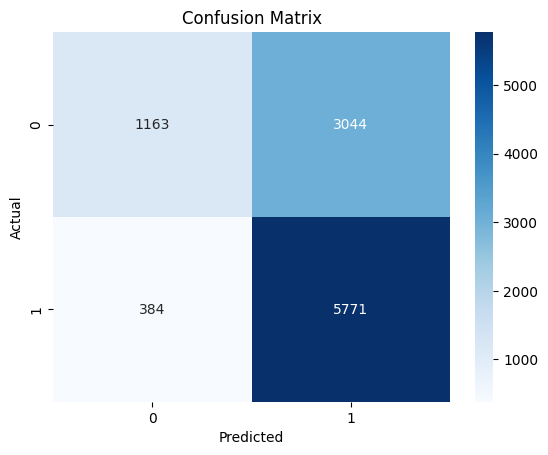

In [4]:
import joblib
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


scaler = joblib.load("scaler.bin")

y_final_pred = loaded_model.predict(scaler.transform(yhat))
y_pred_true = np.argmax(y_final_pred, axis=1)

y_pred_true = y_pred_true.tolist()
print(pd.unique(y_final_true))

print(all(isinstance(x, int) for x in y_final_true))

# Evaluate the model
print('Best Neural Network classification report:')
print(classification_report(y_final_true, list(y_pred_true)))

# Confusion matrix
conf_matrix_nn = confusion_matrix(y_final_true, list(y_pred_true))
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
